# Helpers

In [ ]:
!python -m pip install ipympl
!python -m pip install seaborn

In [ ]:
%matplotlib widget
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from itertools import chain
import scipy
import seaborn as sns
sns.set_theme(style="darkgrid")
from vw_executor.vw import Vw
from vw_executor.loggers import ConsoleLogger


def new_ax():
    _,ax = plt.subplots(dpi=100, figsize=[9,4])
    return ax        

class Simulation:
    def __init__(self, n=10000, swap_after=5000, variance = 0, bad_log = 0):
        print('construct')
        self.examples = []
        self.args = {'n': n, 'swap_after': swap_after, 'variance': variance, 'bad_log': bad_log}
        offset = 0
        for i in range(1, n):
            if i % swap_after == 0:
                offset = (offset + 1) % 2

            person = i % 2 # random.randint(0, 1)
            chosen = i % 4  // 2 #random.randint(0, 1)
            if (chosen + person + offset) % 2 == 0:
                reward =  0.7 + ((chosen + offset) % 2) * 0.1#int(random.random() < 0.7 + ((chosen + offset) % 2) * 0.1)
            else:
                reward = 0.3 - ((chosen + offset + 1) % 2) * 0.1 #int(random.random() < 0.3 - ((chosen + offset + 1) % 2) * 0.1)

            reward = reward + scipy.random.normal(0, variance)

            self.examples.append({
                "reward": reward,
                "shared_good": person,
                "a1_good": '0',
                "a2_good": '1',
                "chosen": chosen, 
                "prob": 0.5
            })
            bad = 2**bad_log
            for i in range(bad):
                self.examples[-1][f'a1_bad_{i}'] = random.random()
                self.examples[-1][f'a2_bad_{i}'] = random.random()
        self.df = pd.DataFrame(self.examples)
    
    def get(self):
        return self.df
    
    def to_dsjson(self):
        for row in self.examples:
            o = {
                "_label_cost": -row['reward'],
                "_label_probability": row['prob'],
                "_label_Action": int(row['chosen'] + 1),
                "_labelIndex": int(row['chosen']),
                "a": [row['chosen'] + 1, (row['chosen'] + 1) % 2 + 1],
                "c": {'shared': {'f': str(row['shared_good'])},
                    '_multi': [{'a': {'f': str(row['a1_good']), 'constant': 1}},
                        {'a': {'f': str(row['a2_good'])}}]},
                "p": [row['prob'], 1 - row['prob']] 
            }
            i = 0
            while True:
                if f'a1_bad_{i}' in row:
                    if 'b' not in o['c']['_multi'][0]: 
                        o['c']['_multi'][0]['b'] = {}
                        o['c']['_multi'][1]['b'] = {}   
                    o['c']['_multi'][0]['b'][f'a1_bad_{i}'] = row[f'a1_bad_{i}']
                    o['c']['_multi'][1]['b'][f'a2_bad_{i}'] = row[f'a2_bad_{i}']
                    i += 1
                else:
                    break
            yield json.dumps(o, separators=(",", ":"))

    def to_dsjson_file(self, fname):
        with open(fname, 'w') as f:
            for ex in self.to_dsjson():
                f.write(f'{ex}\n')             

    def visualize(self, window=100, ax = None):
        colors = ['green', 'red']
        styles = ['-', '-.']
        if ax is None:
            ax = (new_ax(), new_ax())
        [self.df[(self.df['shared_good']==i) & (self.df['chosen']==j)].rolling(window=window)['reward'].mean().plot(
            ax=ax[1], color = colors[j], style=styles[i], label=f'Person: {i}, chosen: {j}') for i in [0,1] for j in [0,1]]
        [self.df[self.df['chosen']==j].rolling(window=window)['reward'].mean().plot(
            ax=ax[0], color = colors[j], label=f'Chosen: {j}') for j in [0,1]]     
        ax[1].legend(loc='center left', bbox_to_anchor=(0.75, 0.5))
        ax[0].legend()
        
def _predictions_parse(lines):
    for l in lines:
        if ':' in l:
            yield {int(kv.split(':')[0]): float(kv.split(':')[1]) for kv in l.split(',')}

def predictions_2_df(files):
    return pd.DataFrame(_predictions_parse(chain(*map(lambda f: open(f), files))))
    
def plot(sim, job, ax):
    colors = ['green', 'red']
    styles = ['-', '-.']
    prediction_files = job.outputs['-p']
    df = pd.concat([sim.get(), predictions_2_df(prediction_files)], axis=1)
    [(df[(df['shared_good']==i)][j].rolling(window=100).mean() + i * 0.05).plot(
        ax=ax, color = colors[j], style=styles[i], label=f'P(chosen={j} | Person={i})') for i in [0,1] for j in [0,1]]
    ax.legend(loc='center left', bbox_to_anchor=(0.75, 0.5))
    
    
def vw_playground(n=10000, swap_after=5000, variance=0, bad_log=0, window=100, 
                       learning_rate=-20, coin=False, l1=-20, cb_type='ips', 
                       interactions='', ignore='', ignore_linear='', marginals='', ax=None, fig=None, state = {'sim': Simulation(10000, 5000, 0, 0), 'previous_window': -1}):

    simulation_args = {'n': n, 'swap_after': swap_after, 'variance': variance, 'bad_log': bad_log}
    if state['sim'].args != simulation_args:
        print('generating')
        state['sim'] = Simulation(n=n, swap_after=swap_after, variance = variance, bad_log = bad_log)
        state['sim'].to_dsjson_file('small.json')
        ax[0][0].clear()
        ax[0][1].clear()
        ax[0][1].set_title('Rewards')
        ax[0][0].set_title('Rewards (nonpersonalized)')
        state['sim'].visualize(window = window, ax=ax[0]) 
    else:
        if window != state['previous_window']:
            ax[0][0].clear()
            ax[0][1].clear()
            ax[0][1].set_title('Rewards')
            ax[0][0].set_title('Rewards (nonpersonalized)')
            state['sim'].visualize(window = window, ax=ax[0])   
            state['previous_window'] = window


    ax[1][0].clear()
    ax[1][1].clear()

    ax[1][1].set_title('P(action|person)')

    opts = {'#base': '--cb_explore_adf --dsjson --epsilon 0.2',
            '#0': interactions,
            '#1': ignore,
            '#2': ignore_linear,
            '#3': marginals,
            '#lr': '--coin' if coin else f'--power_t 0 --learning_rate {2**learning_rate}',
            '--l1': 2**l1,
            '--cb_type': cb_type
           }

    result = Vw('vw', '.vw_cache', handlers=[],
                loggers=[
     #              ConsoleLogger('DEBUG')
                ]).train(['small.json'], opts, ['-p'])


    plot(state['sim'], result, ax[1][1])
    fig.canvas.draw_idle()

# Look at the data

In [13]:
sim = Simulation(n=100, swap_after=50, variance = 0.1, bad_log = 1)
sim.get().head()

construct


,reward,shared_good,a1_good,a2_good,chosen,prob,a1_bad_0,a2_bad_0,a1_bad_1,a2_bad_1
0,0.242801,1,0,1,0,0.5,0.327688,0.742516,0.345441,0.949529
1,0.533476,0,0,1,1,0.5,0.100850,0.796198,0.896277,0.830136
2,0.959965,1,0,1,1,0.5,0.791026,0.339709,0.168648,0.720831
3,0.776782,0,0,1,0,0.5,0.023869,0.407586,0.856761,0.873843
4,0.308086,1,0,1,0,0.5,0.586457,0.428704,0.940760,0.547959


construct


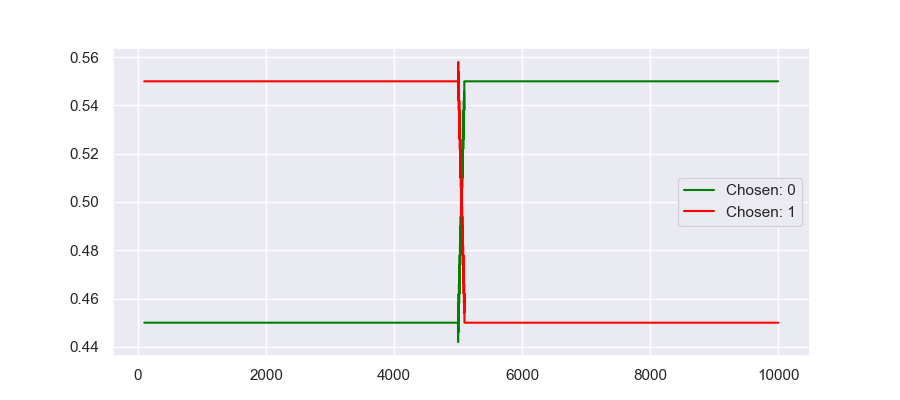

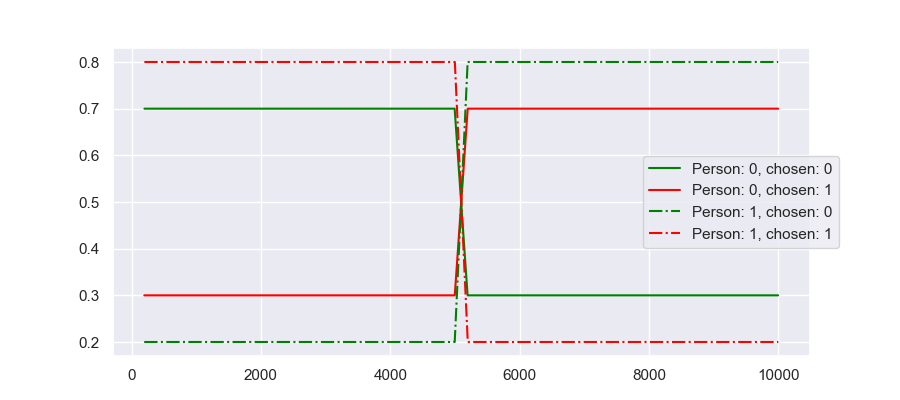

In [14]:
Simulation(n=10000, swap_after=5000, variance = 0, bad_log = 1).visualize(window=50)

In [15]:
json.loads(next(Simulation(n=10000, swap_after=5000, variance = 0, bad_log = 1).to_dsjson()))

construct


{'_label_cost': -0.19999999999999998,
 '_label_probability': 0.5,
 '_label_Action': 1,
 '_labelIndex': 0,
 'a': [1, 2],
 'c': {'shared': {'f': '1'},
  '_multi': [{'a': {'f': '0', 'constant': 1},
    'b': {'a1_bad_0': 0.13195642772132188, 'a1_bad_1': 0.37651894122870355}},
   {'a': {'f': '1'},
    'b': {'a2_bad_0': 0.011454508746632786, 'a2_bad_1': 0.4045320825540012}}]},
 'p': [0.5, 0.5]}

# Interact

In [ ]:
from ipywidgets import *

fig, ax = plt.subplots(2, 2, figsize=(12,7))

state = {'sim': Simulation(10000, 5000, 0, 0), 'previous_window': -1}
widget = interactive(
    vw_playground,
    n=IntSlider(min=1000, max=20000, step=1000, value=state['sim'].args['n']),
    swap_after=IntSlider(min=1000, max=20000, step=1000, value=state['sim'].args['swap_after']),
    variance=FloatSlider(min=0, max=2, step=0.1, value=state['sim'].args['variance']),
    bad_log=IntSlider(min=0, max=10, step=1, value = state['sim'].args['bad_log']),
    window=IntSlider(min=1, max=1000, step=10, value = 1),
    learning_rate=IntSlider(min=-20,max=10, step=1, value=-20),
    coin=Checkbox(),
    l1=IntSlider(min=-20,max=10, step=1, value=-20),
    cb_type=['ips', 'mtr'],
    interactions=['', '-q sa', '-q ab', '-q sb', '-q ::'],
    ignore=['', '--ignore b'],
    ignore_linear=['', '--ignore_linear sab'],
    marginals=['', '--marginal a'],
    ax=fixed(ax),
    fig=fixed(fig),
    state=fixed(state))

data_controls = HBox(widget.children[:4])
visualization_controls = HBox(widget.children[4:5])
learning_controls = HBox((Label("Step 1", layout=Layout(display="flex", justify_content="flex-start", width="4%")),) + widget.children[5:-5])
extra = HBox((Label("Step 2", layout=Layout(display="flex", justify_content="flex-start", width="4%")),) + widget.children[-5:-1])
output = widget.children[-1]
display(VBox([data_controls, visualization_controls, learning_controls, extra, output]))

In [ ]:
import itertools
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

from vw_executor.vw import Vw
from vw_executor.vw_opts import product, dimension
import pandas as pd

vw = Vw('vw', '.vw_cache')

step1 = pd.DataFrame(product(
    dimension('#base', ['--cb_explore_adf -P 1000 --preserve_performance_counters --save_resume --dsjson --power_t 0']),
    dimension('--learning_rate', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]),
    dimension('--l1', [1e-9, 1e-6, 1e-3]),
    dimension('--cb_type', ['ips', 'mtr']),
    dimension('#marginal', ['', '--marginal a'])    # HAVE TO BE EXTRACTED FROM THE DATA
    ))

step2 = pd.DataFrame(
    dimension('#interactions', [f'-q {" ".join([t[0] + t[1] for t in c])}'
                                for c in powerset((itertools.product(['s'], ['a', 'b'])))]))   # HAVE TO BE EXTRACTED FROM THE DATA
inputs = ['small.json']

# sweep
first_step_best = vw.train(inputs, step1).sort_values('!Loss').head(1)
second_step_best = vw.train(inputs, pd.DataFrame(product(first_step_best, step2))).sort_values('!Loss').head(1)
third_step_best = vw.train(inputs, pd.DataFrame(product(second_step_best, step1))).sort_values('!Loss').head(1)

# predict
vw.train(inputs, third_step_best, ['-p'])